In [38]:
import numpy as np

class DecisionNode:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, *, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value


In [39]:
def gini(y):
    classes = np.unique(y)
    impurity = 1
    for cls in classes:
        p_cls = np.mean(y == cls)
        impurity -= p_cls ** 2
    return impurity

def entropy(y):
    classes = np.unique(y)
    entropy = 0
    for cls in classes:
        p_cls = np.mean(y == cls)
        if p_cls > 0:
            entropy -= p_cls * np.log2(p_cls)
    return entropy

def mse(y):
    return np.mean((y - np.mean(y)) ** 2)


In [40]:
class DecisionTree:
    def __init__(self, 
                 task='classification', 
                 max_depth=100, 
                 min_samples_split=2, 
                 min_impurity_decrease=1e-7):
        self.task = task
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_impurity_decrease = min_impurity_decrease
        self.root = None
        
        if self.task == 'classification':
            self.criterion = gini
        elif self.task == 'regression':
            self.criterion = mse
        else:
            raise ValueError("Task must be 'classification' or 'regression'.")

    def fit(self, X, y):
        self.root = self._build_tree(X, y)
    
    def _build_tree(self, X, y, depth=0):
        num_samples, num_features = X.shape
        current_impurity = self.criterion(y)
        
        if (depth >= self.max_depth or 
            num_samples < self.min_samples_split or 
            current_impurity == 0):
            leaf_value = self._calculate_leaf_value(y)
            return DecisionNode(value=leaf_value)
        
        best_feature, best_threshold, best_impurity_decrease = self._best_split(X, y, current_impurity)
        
        if best_impurity_decrease < self.min_impurity_decrease:
            leaf_value = self._calculate_leaf_value(y)
            return DecisionNode(value=leaf_value)
        
        left_indices = X[:, best_feature] < best_threshold
        right_indices = X[:, best_feature] >= best_threshold
        left = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right = self._build_tree(X[right_indices], y[right_indices], depth + 1)
        return DecisionNode(feature_index=best_feature, threshold=best_threshold, left=left, right=right)
    
    def _best_split(self, X, y, current_impurity):
        num_samples, num_features = X.shape
        best_impurity_decrease = 0
        best_feature, best_threshold = None, None
        
        for feature in range(num_features):
            thresholds, classes = zip(*sorted(zip(X[:, feature], y)))
            for i in range(1, num_samples):
                if classes[i] == classes[i-1]:
                    continue
                threshold = (thresholds[i] + thresholds[i-1]) / 2
                if self.task == 'classification':
                    left = y[:i]
                    right = y[i:]
                    impurity = self.criterion(left) * (i / num_samples) + self.criterion(right) * ((num_samples - i) / num_samples)
                else:
                    left = y[:i]
                    right = y[i:]
                    impurity = self.criterion(left) * (i / num_samples) + self.criterion(right) * ((num_samples - i) / num_samples)
                
                impurity_decrease = current_impurity - impurity
                
                if impurity_decrease > best_impurity_decrease:
                    best_impurity_decrease = impurity_decrease
                    best_feature = feature
                    best_threshold = threshold
                    
        return best_feature, best_threshold, best_impurity_decrease
    
    def _calculate_leaf_value(self, y):
        if self.task == 'classification':
            values, counts = np.unique(y, return_counts=True)
            return values[np.argmax(counts)]
        else:
            return np.mean(y)
    
    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])
    
    def _traverse_tree(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature_index] < node.threshold:
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)


In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error

def plot_classification_data(X, y, title="Classification Data"):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[y==0][:,0], X[y==0][:,1], color='blue', label='Class 0', edgecolor='k')
    plt.scatter(X[y==1][:,0], X[y==1][:,1], color='red', label='Class 1', edgecolor='k')
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title(title)
    plt.legend()
    plt.show()

def plot_decision_boundary(tree, X, y, title="Decision Boundary"):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    resolution = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = tree.predict(grid)
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.RdBu)
    plt.scatter(X[y==0][:,0], X[y==0][:,1], color='red', label='Class 0', edgecolor='k')
    plt.scatter(X[y==1][:,0], X[y==1][:,1], color='blue', label='Class 1', edgecolor='k')
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title(title)
    plt.legend()
    plt.show()


def classification_example():
    X, y = make_classification(n_samples=200, n_features=2,
                               n_redundant=0, n_clusters_per_class=1,
                               class_sep=1.5, random_state=41)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.3, 
                                                        random_state=42)
    
    plot_classification_data(X_train, y_train, title="Training Data - Classification")
    
    clf = DecisionTree(task='classification', max_depth=15, min_samples_split=10)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Classification Accuracy: {accuracy:.4f}')
    
    plot_decision_boundary(clf, X_train, y_train, title="Decision Boundary - Classification")

def plot_regression_data(X, y, title="Regression Data"):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', edgecolor='k')
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title(title)
    plt.colorbar(label='Target Value')
    plt.show()

def plot_regression_decision_boundary(tree, X, y, title="Decision Boundary - Regression"):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    resolution = 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = tree.predict(grid)
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(8, 6))
    contour = plt.contourf(xx, yy, Z, alpha=0.4, cmap='viridis')
    plt.colorbar(contour, label='Predicted Value')
    plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', edgecolor='k')
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title(title)
    plt.show()

def regression_example():
    X, y = make_regression(n_samples=200, n_features=2, noise=15.0, random_state=42)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.3, 
                                                        random_state=42)
    
    plot_regression_data(X_train, y_train, title="Training Data - Regression")
    
    reg = DecisionTree(task='regression', max_depth=5, min_samples_split=10)
    reg.fit(X_train, y_train)
    
    y_pred = reg.predict(X_test)
    
    mse_value = mean_squared_error(y_test, y_pred)
    print(f'Regression MSE: {mse_value:.4f}')
    
    plot_regression_decision_boundary(reg, X_train, y_train, title="Decision Boundary - Regression")



=== Classification Example ===


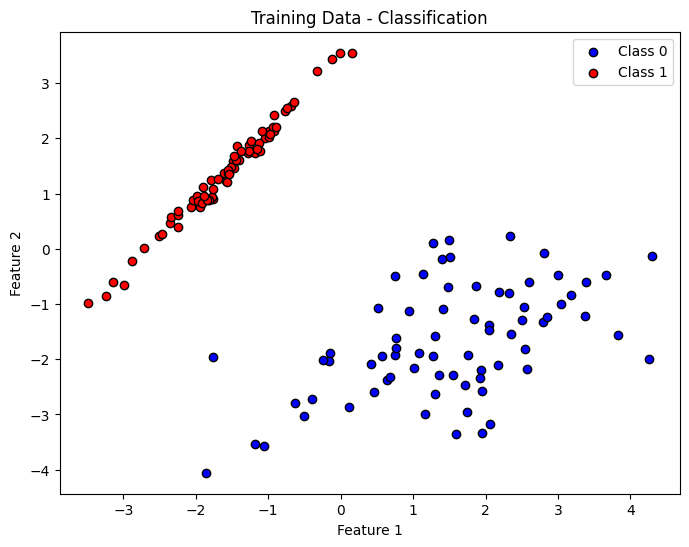

Classification Accuracy: 0.9667


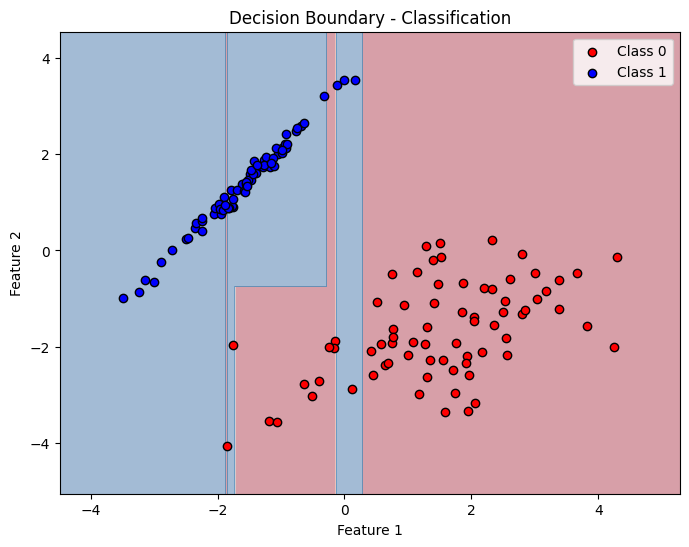


=== Regression Example ===


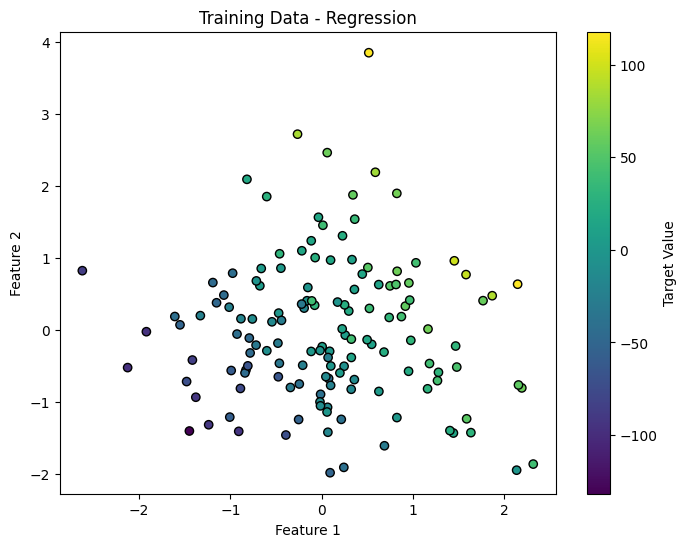

Regression MSE: 1263.5699


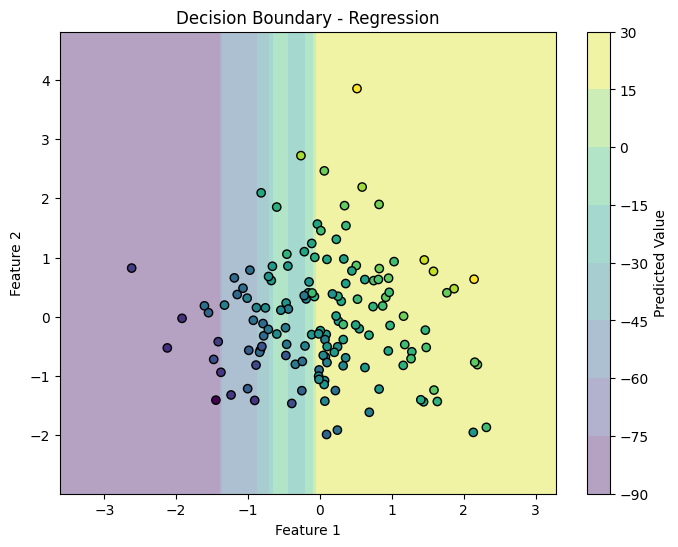

In [42]:
print("=== Classification Example ===")
classification_example()
print("\n=== Regression Example ===")
regression_example()